In [52]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib import patches

In [86]:
image_path_1 = "img/0281.jpg"
image_path_2 = "img/0283.jpg"

In [102]:
color_img = cv.imread(image_path_1)
img_1 = cv.cvtColor(color_img, cv.COLOR_BGR2GRAY)
color_img = cv.imread(image_path_2)
img_2 = cv.cvtColor(color_img, cv.COLOR_BGR2GRAY)

In [82]:
r = cv2.selectROI(img_1)
rect = [(r[0],r[1]),(r[0]+r[2],r[1]+r[3])]

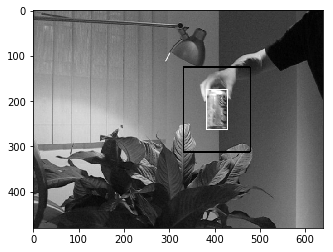

In [105]:
plt.imshow(img_1,cmap = 'gray')
plt.show()

In [288]:
my_object = img_1[rect[0][1]:rect[1][1],rect[0][0]:rect[1][0]]

cropped_img_1 = img_1[rect_seak[0][1]:rect_seak[1][1],rect_seak[0][0]:rect_seak[1][0]]
cropped_img_2 = img_2[rect_seak[0][1]:rect_seak[1][1],rect_seak[0][0]:rect_seak[1][0]]

In [164]:
def ssd(A, B):
    return np.sum((A[:,:]-B[:,:])**2)

In [197]:
def ncc(A, B):
    A = (A - A.mean())
    B = (B - B.mean())
    return np.sum((A[:,:]*B[:,:]))/np.sqrt((A**2).sum()*(B**2).sum())

In [198]:
def sad(A, B, zero_mean = False):
    if zero_mean:
        A = (A - A.mean())
        B = (B - B.mean())
    
    return np.sum(abs(A[:,:]-B[:,:]))

In [181]:
my_object = my_object.astype('float32')
cropped_img_2 = cropped_img_2.astype('float32')

<class 'numpy.float32'>
<class 'numpy.float32'>


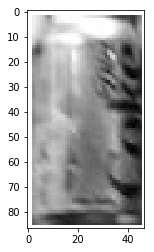

In [119]:
plt.imshow(my_object,cmap="gray")


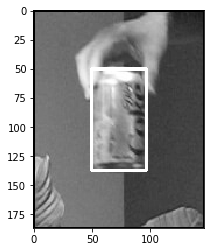

In [122]:
plt.imshow(cropped_img_1,cmap="gray")

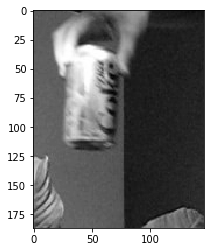

In [121]:
plt.imshow(cropped_img_2,cmap="gray")

In [167]:
ssd_img = np.ones((len(cropped_img_2) - len(my_object), len(cropped_img_2[0]) - len(my_object[0])), np.float32)
for x in range(len(cropped_img_2) - len(my_object)):
    for y in range(len(cropped_img_2[0]) - len(my_object[0])):
        candidate = cropped_img_2[x:x+len(my_object),y:y+len(my_object[0])]
        ssd_img[x][y] = ssd(my_object, candidate)

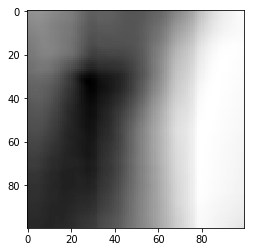

In [168]:
plt.imshow(ssd_img,cmap="gray")

In [193]:
ncc_img = np.ones((len(cropped_img_2) - len(my_object), len(cropped_img_2[0]) - len(my_object[0])), np.float32)
for x in range(len(cropped_img_2) - len(my_object)):
    for y in range(len(cropped_img_2[0]) - len(my_object[0])):
        candidate = cropped_img_2[x:x+len(my_object),y:y+len(my_object[0])]
        ncc_img[x][y] = ncc(my_object, candidate)

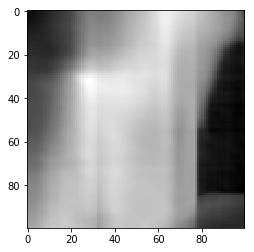

In [194]:
plt.imshow(ncc_img,cmap="gray")

In [199]:
sad_img = np.ones((len(cropped_img_2) - len(my_object), len(cropped_img_2[0]) - len(my_object[0])), np.float32)
for x in range(len(cropped_img_2) - len(my_object)):
    for y in range(len(cropped_img_2[0]) - len(my_object[0])):
        candidate = cropped_img_2[x:x+len(my_object),y:y+len(my_object[0])]
        sad_img[x][y] = sad(my_object, candidate)

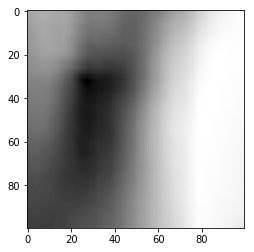

In [200]:
plt.imshow(sad_img,cmap="gray")

### Lukas-Kanade

Method does not converge, I don't know why. I tested all the parts separately, they seems to work fine. 

In [207]:
def warp(x, y, p, warp_type='opticflow'): #type='opticflow','affine'
    vec = np.asarray([x, y, 1]).T    
    if (warp_type == 'opticflow' or warp_type == 'affine'):
        return np.dot(p,vec)
    else:
        raise ValueError("type must be 'opticflow' or 'affine'")

In [224]:
def jakobian(x, y, warp_type):
       
    if warp_type == 'opticflow': 
        return [[1,0,0,0,0,0],[0,1,0,0,0,0]]
    elif warp_type == 'affine':
        return [[x,0,y,0,1,0],[0,x,0,y,0,1]]
    else:
        raise ValueError("type must be 'opticflow' or 'affine'")

In [252]:
def hessian(steep_desc_im):
    return np.dot(steep_desc_im.T, steep_desc_im)

In [319]:
warp_type = 'affine'
threshold = 0.1
dp = np.asarray([1,1,1,1,1,1])
p1 = 4
p2 = 9
p = [[1, 0, p1], [0, 1, p2]]
[gx, gy] = np.gradient(cropped_img_2)
while (np.sqrt(np.dot(dp.T,dp))>threshold):
    warped_i = np.ones((len(my_object), len(my_object[0])), np.float32)
    for x in range(len(my_object)):
        for y in range(len(my_object[0])):
            [x_new,y_new] = warp(x,y,p)
            warped_i[x][y] = cropped_img_2[min(len(cropped_img_2)-1,int(x_new)),min(len(cropped_img_2[0])-1,int(y_new))]
    error = my_object - warped_i   
    warped_gx = np.ones((len(my_object), len(my_object[0])), np.float32)
    warped_gy = np.ones((len(my_object), len(my_object[0])), np.float32)
    steep_desc_im = np.ones((len(my_object)*len(my_object[0]), 6), np.float32)

    for x in range(len(my_object)):
        for y in range(len(my_object[0])):
            [x_new,y_new] = warp(x,y,p)
            warped_gx[x][y] = gx[min(len(cropped_img_2)-1,int(x_new)),min(len(cropped_img_2[0])-1,int(y_new))]
            warped_gy[x][y] = gy[min(len(cropped_img_2)-1,int(x_new)),min(len(cropped_img_2[0])-1,int(y_new))]
            steep_desc_im[x*len(my_object[0]) + y, :] = np.dot([warped_gx[x][y], warped_gy[x][y]],jakobian(x, y, warp_type))
    hes = hessian(steep_desc_im)
    sper_desc_par_updates = np.dot(steep_desc_im.T,error.flatten())
    dp = np.dot(np.linalg.inv(hes),sper_desc_par_updates) #maybe sper_desc_par_updates.T
    p = p+dp.reshape(2,3)
    print(np.sqrt(np.dot(dp.T,dp)))

1.0416113
0.7111386
0.50790656
0.54561883
0.5527001
0.608384
0.6661448
0.688334
0.7032756
0.7477871
0.7705492
0.78326494
0.8243298
0.8097079
0.81442165
0.81270915
0.840126
0.83266
0.8297893
0.85954493
0.8481843
0.8391748
0.90591365
0.92010176
0.922852
0.936716
0.95568305
0.9171467
0.9348003
0.9667083
0.9917495
0.97541976
0.943154
0.970342
0.99920076
0.9834005
0.9869292
1.0168153
1.0094761
0.9861439
0.9844735
0.9227529
0.9086484
0.87672913
0.88974905
0.9029183
0.926621
0.9356501
0.93510574
0.9836066
0.9821448
1.0004038
0.9428598
0.9747813
0.954669
0.93679833
0.94762874
0.96379143
0.9408716
0.9442618
0.94362664
0.9283134
0.9178554
0.92700106
0.91502285
0.91043836
0.9091467
0.89779127
0.88165706
0.87973887
0.8808177
0.87978315
0.8733774
0.8762143
0.88427514
0.90055656
0.9110592
0.92953795
0.9330594
0.9348432
0.9332613
0.9164932
0.91627926
0.90305424
0.8994476
0.90736115
0.9148749
0.917192
0.92369646
0.9146705
0.9182931
0.9189433
0.91966486
0.91165024
0.9234168
0.92517334
0.91857135
0.9192

IndexError: index -188 is out of bounds for axis 0 with size 187